In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-segmentation/bank_transactions.csv


In [2]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.3 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly import plot
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from itertools import product
from sklearn.cluster import estimate_bandwidth,MeanShift
import joblib
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df=pd.read_csv('/kaggle/input/bank-customer-segmentation/bank_transactions.csv')

In [5]:
df.rename(columns={'CustomerID':'ID','CustomerDOB':'Date_Birth','CustGender':'Gender','CustLocation':'Location',
                    'CustAccountBalance':'AccountBalance'},inplace=True)
df.head()

,TransactionID,ID,Date_Birth,Gender,Location,AccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   ID                       1048567 non-null  object 
 2   Date_Birth               1045170 non-null  object 
 3   Gender                   1047467 non-null  object 
 4   Location                 1048416 non-null  object 
 5   AccountBalance           1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [7]:
df.describe()

,AccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.570875e+05,1.574335e+03
std,8.464854e+05,5.126185e+04,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.240300e+05,1.610000e+02
50%,1.679218e+04,1.642260e+05,4.590300e+02
75%,5.765736e+04,2.000100e+05,1.200000e+03
max,1.150355e+08,2.359590e+05,1.560035e+06


In [8]:
df.TransactionDate=pd.to_datetime(df.TransactionDate,format="%d/%m/%y")

In [9]:
def take_day(date): return int(date.split('/')[0]) if pd.notna(date) and int(date.split('/')[2])!=1800 else None
def take_month(date): return int(date.split('/')[1]) if pd.notna(date) and int(date.split('/')[2])!=1800 else None
def take_year(date): return int(date.split('/')[2]) if pd.notna(date) and int(date.split('/')[2])!=1800 else None
df['Day_Birth']=df['Date_Birth'].apply(take_day)
df['Month_Birth']=df['Date_Birth'].apply(take_month)
df['Year_Birth']=df['Date_Birth'].apply(take_year)
df['TransactionDay']=df.TransactionDate.dt.day
df['TransactionMonth']=df.TransactionDate.dt.month
df['TransactionYear']=df.TransactionDate.dt.year


In [10]:
df.Gender.unique()

array(['F', 'M', nan, 'T'], dtype=object)

In [11]:
#loc_gen=pd.DataFrame(df.groupby('Location').Gender.value_counts()).reset_index()
#locations=loc_gen.Location.unique()
#for loc in locations:
    #gen_type=loc_gen[loc_gen.Location==loc].Gender
    #df[df.Location==loc]=df[df.Location==loc].fillna({'Gender':gen_type})
most_freq_gender=df.Gender.value_counts().iloc[[0]].index[0]
df=df.fillna({'Gender':most_freq_gender})
df[['Location']]=SimpleImputer(strategy='most_frequent').fit_transform(df[['Location']])
df=df.dropna(subset='AccountBalance')
date_cols=['Day_Birth','Month_Birth','Year_Birth']
for col in date_cols:
    average=int(df[col].mean())
    df.fillna({col:average},inplace=True)

In [12]:
corr=df.corr(numeric_only=True,)
corr.style.background_gradient('coolwarm')

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3618: RuntimeWarning:

All-NaN slice encountered

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3619: RuntimeWarning:

All-NaN slice encountered



,AccountBalance,TransactionTime,TransactionAmount (INR),Day_Birth,Month_Birth,Year_Birth,TransactionDay,TransactionMonth,TransactionYear
AccountBalance,1.000000,-0.004094,0.062623,-0.000410,0.005970,-0.110824,0.008428,-0.000804,nan
TransactionTime,-0.004094,1.000000,0.007852,0.003805,0.003213,0.000850,0.013105,0.021710,nan
TransactionAmount (INR),0.062623,0.007852,1.000000,-0.003026,0.000134,-0.091930,-0.002201,0.000147,nan
Day_Birth,-0.000410,0.003805,-0.003026,1.000000,0.057162,0.020195,-0.000161,0.000914,nan
Month_Birth,0.005970,0.003213,0.000134,0.057162,1.000000,-0.013075,0.001794,-0.001672,nan
Year_Birth,-0.110824,0.000850,-0.091930,0.020195,-0.013075,1.000000,-0.019455,0.009507,nan
TransactionDay,0.008428,0.013105,-0.002201,-0.000161,0.001794,-0.019455,1.000000,-0.291585,nan
TransactionMonth,-0.000804,0.021710,0.000147,0.000914,-0.001672,0.009507,-0.291585,1.000000,nan
TransactionYear,nan,nan,nan,nan,nan,nan,nan,nan,nan


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



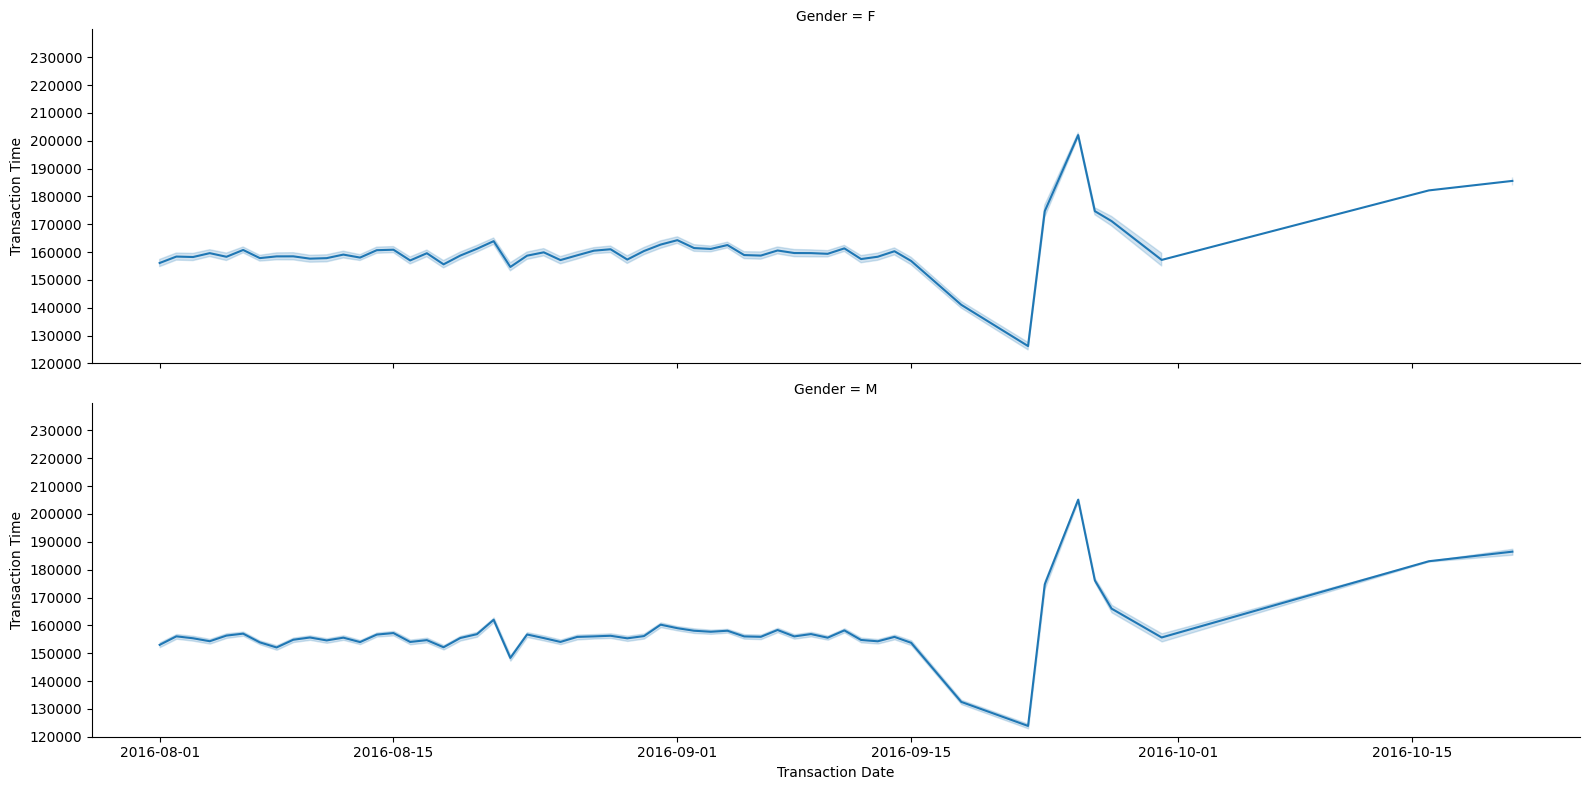

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning:

Using the countplot function without specifying `order` is likely to produce an incorrect plot.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



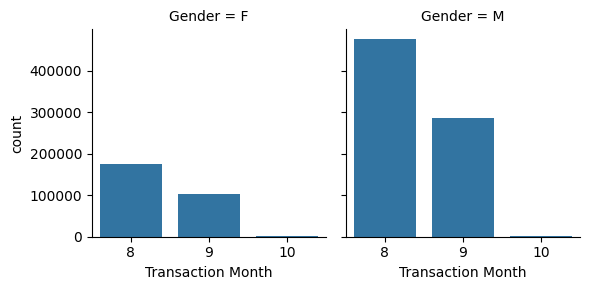

In [13]:
def make_facetGrid(plot_type,x_value,y_value=None,row=None,col='Gender'):
    if plot_type==sns.lineplot:
        facet=sns.FacetGrid(data=df[df.Gender!='T'],col=col,col_wrap=1,aspect=4,height=4,)
        facet.map(plot_type,x_value,y_value)
        facet.set(ylim=(120000,240000),yticks=np.arange(120000,240000,10000))
        facet.set_axis_labels("Transaction Date", "Transaction Time")
    else:
        facet=sns.FacetGrid(data=df[df.Gender!='T'],col=col,col_wrap=2,height=3,sharex=False)
        facet.map(plot_type,x_value)
        facet.set_axis_labels("Transaction Month")
    plt.show()
make_facetGrid(sns.lineplot,'TransactionDate','TransactionTime')
make_facetGrid(sns.countplot,'TransactionMonth')

In [14]:
tr_max=df.groupby(['TransactionDate'])[['AccountBalance','TransactionTime','TransactionAmount (INR)']].median().reset_index()
tr_mean=df.groupby(['TransactionDate'])[['AccountBalance','TransactionTime','TransactionAmount (INR)']].mean().reset_index()
tr_data=pd.merge(tr_max,tr_mean,left_on='TransactionDate',right_on='TransactionDate')
layout=go.Layout(title='Transaction Deep Statistics',
                 xaxis=dict(title='TransactionDate',titlefont=dict(
                     size=18,family='Courier New, monospace',color='#2c3e50')),
                 yaxis=dict(title='TransactionCol',titlefont=dict(
                     size=18,family='Courier New, monospace',color='#3498db')) )
def make_plot_tr(col_name1,col_name2,col_label_name): 
    plot1=go.Scatter(x=tr_data.TransactionDate,y=tr_data[col_name1],mode='lines',name='median')
    plot2=go.Scatter(x=tr_data.TransactionDate,y=tr_data[col_name2],mode='lines',name='average')
    layout.yaxis.title.text=col_label_name
    plot_data=go.Figure(data=[plot1,plot2],layout=layout,)
    iplot(plot_data)
make_plot_tr('TransactionTime_x','TransactionTime_y','Transaction Time')
make_plot_tr('AccountBalance_x','AccountBalance_y','Account Balance')
make_plot_tr('TransactionAmount (INR)_x','TransactionAmount (INR)_y','Transaction Amount')

<Axes: xlabel='Year_Birth', ylabel='TransactionAmount (INR)'>

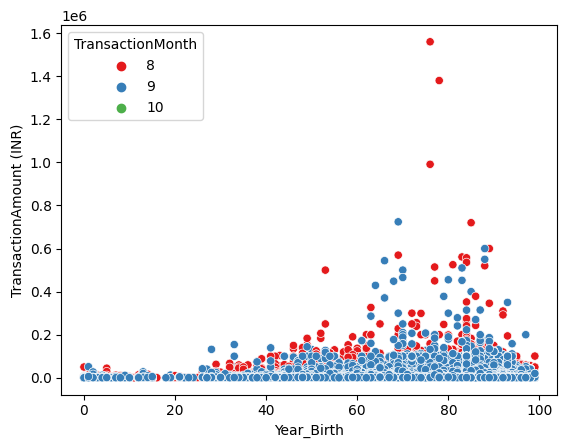

In [15]:
sns.scatterplot(data=df,x='Year_Birth',y='TransactionAmount (INR)',
                hue='TransactionMonth',palette='Set1')

/tmp/ipykernel_32/1783676571.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



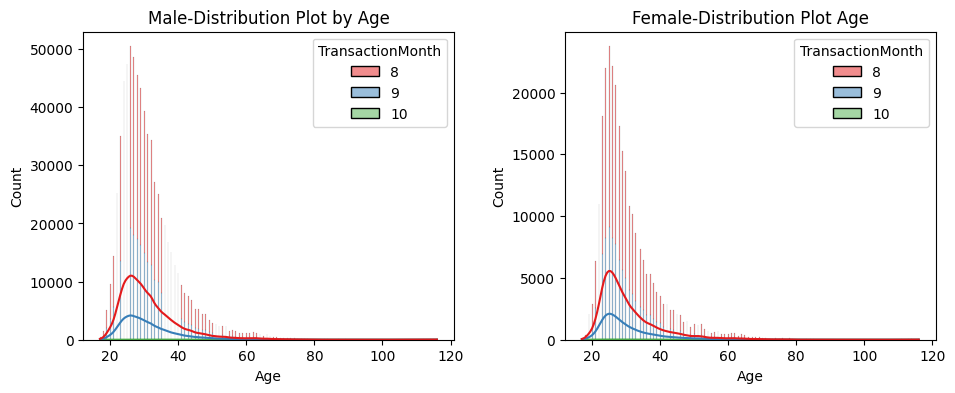

In [16]:
df_not_1800=df[df.Date_Birth!='1/1/1800']
data_age=df_not_1800.TransactionYear-(df_not_1800.Year_Birth+1900)
df_not_1800['Age']=data_age
age_male=df_not_1800[df_not_1800.Gender=='M']
age_female=df_not_1800[df_not_1800.Gender=='F']
def make_distribution(x_value):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,4))
    fig.subplots_adjust(wspace=0.3,)
    sns.histplot(ax=ax1,data=age_male,x=x_value,hue='TransactionMonth',
             palette='Set1',multiple='stack',kde=True)
    sns.histplot(ax=ax2,data=age_female,x=x_value,hue='TransactionMonth',
             palette='Set1',multiple='stack',kde=True)

    ax1.set_title(f"Male-Distribution Plot by {x_value}")
    ax2.set_title(f"Female-Distribution Plot {x_value}")
    plt.show()
make_distribution('Age')

In [17]:
ks_statistic,p_value=ks_2samp(age_male['Age'],age_female['Age'])
print('Kolmogorov-Smirnov test statistic: {:.5f}'.format(ks_statistic))
print('Kolmogorov-Smirnov test p_value: {:.5f}'.format(p_value))

Kolmogorov-Smirnov test statistic: 0.07863
Kolmogorov-Smirnov test p_value: 0.00000


* In summary, a p-value of 0 in a K-S test indicates strong evidence to reject the null hypothesis, suggesting that the sample distribution is significantly different from the specified distribution.

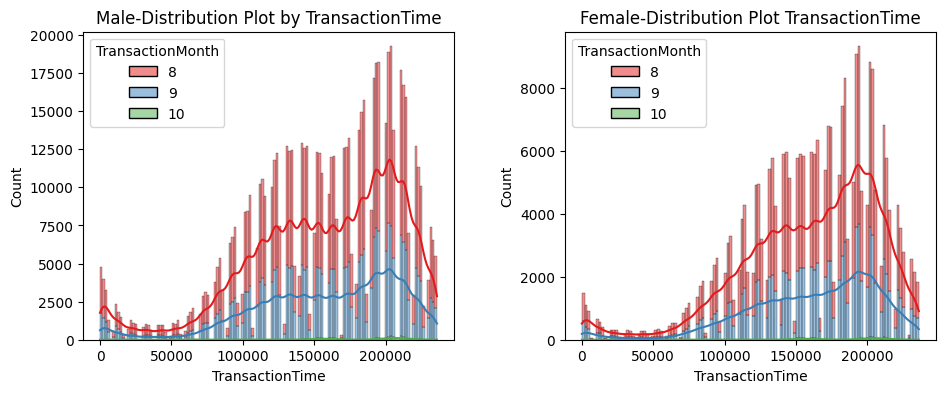

In [18]:
make_distribution('TransactionTime')

In [19]:
ks_statistic,p_value=ks_2samp(age_male['TransactionTime'],age_female['TransactionTime'])
print('Kolmogorov-Smirnov test statistic: {:.5f}'.format(ks_statistic))
print('Kolmogorov-Smirnov test p_value: {:.5f}'.format(p_value))

Kolmogorov-Smirnov test statistic: 0.04678
Kolmogorov-Smirnov test p_value: 0.00000


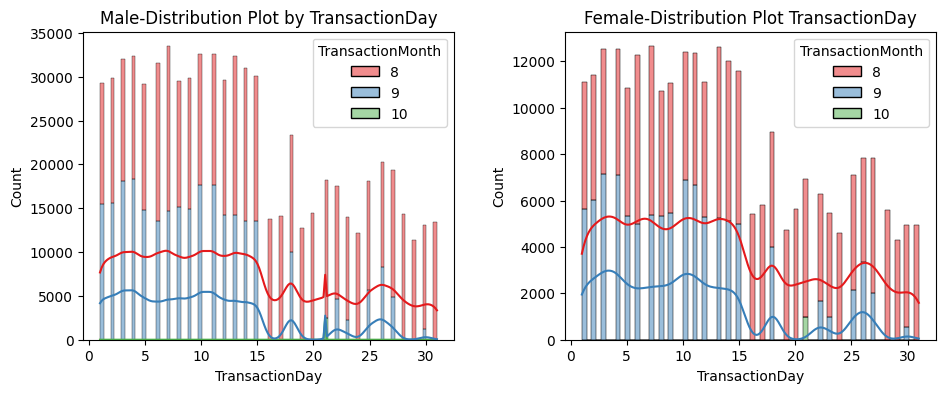

In [20]:
make_distribution('TransactionDay')

In [21]:
ks_statistic,p_value=ks_2samp(age_male['AccountBalance'],age_female['AccountBalance'])
print('Kolmogorov-Smirnov test statistic: {:.5f}'.format(ks_statistic))
print('Kolmogorov-Smirnov test p_value: {:.5f}'.format(p_value))

Kolmogorov-Smirnov test statistic: 0.07837
Kolmogorov-Smirnov test p_value: 0.00000


In [22]:
df['Age']=df['TransactionYear']-(1900+df.Year_Birth)
df=df.drop(['TransactionID','ID','TransactionDate','Date_Birth','TransactionYear'],axis=1)
df.TransactionMonth.replace([8,9,10],['August','September','October'],inplace=True)

df.head()

,Gender,Location,AccountBalance,TransactionTime,TransactionAmount (INR),Day_Birth,Month_Birth,Year_Birth,TransactionDay,TransactionMonth,Age
0,F,JAMSHEDPUR,17819.05,143207,25.0,10.0,1.0,94.0,2,August,22.0
1,M,JHAJJAR,2270.69,141858,27999.0,4.0,4.0,57.0,2,August,59.0
2,F,MUMBAI,17874.44,142712,459.0,26.0,11.0,96.0,2,August,20.0
3,F,MUMBAI,866503.21,142714,2060.0,14.0,9.0,73.0,2,August,43.0
4,F,NAVI MUMBAI,6714.43,181156,1762.5,24.0,3.0,88.0,2,August,28.0


In [23]:
locations = df['Location'].values.reshape(-1, 1)
df['Location']=OrdinalEncoder().fit_transform(locations)
df=df.sample(frac=1,random_state=21).reset_index(drop=True)

In [24]:
num_pipeLine=Pipeline([('standard',StandardScaler())])
cat_oneHot=['Gender','TransactionMonth']
num_standard=['Location','AccountBalance','TransactionTime','TransactionAmount (INR)',
              'Day_Birth','Month_Birth','Year_Birth','TransactionDay','Age']
full_pipe=ColumnTransformer([
    ('one_hot_cat',OneHotEncoder(),cat_oneHot),
    ('numerical',StandardScaler(),num_standard)
])
X_prepared=full_pipe.fit_transform(df)

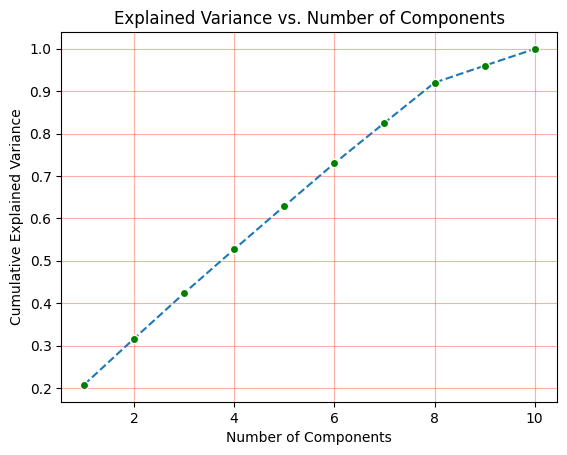

In [26]:
max_components=min(df.shape)-1
pca_scaler=PCA(n_components=max_components)
pca_scaler.fit(X_prepared)
plt.plot(np.arange(1,max_components+1),pca_scaler.explained_variance_ratio_.cumsum(),
         marker='o',linestyle='--',linewidth=1.5,markerfacecolor='green',markeredgecolor='white')
plt.grid(color='tomato',which='both',alpha=0.5)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [27]:
pca_scaler.transform(X_prepared[[0]])

array([[-0.57908023, -0.27727654, -2.24067608,  0.53975942,  0.1236163 ,
         0.36539282,  0.21827053,  0.26708526,  1.19298575, -0.25671048]])

In [28]:
pca_scaler=PCA(n_components=9)
x=pca_scaler.fit_transform(X_prepared)
cluster_num=np.arange(2,11)
cluster_inertia=[]
cluster_score=[]
for n in cluster_num:
    kmeans_est=KMeans(n_clusters=n,init='k-means++',n_init='auto',random_state=23).fit(x)
    cluster_inertia.append(kmeans_est.inertia_)
    #score_result=silhouette_score(X_prepared,kmeans_est.labels_)
    #cluster_score.append(score_result)

In [29]:
joblib.dump(pca_scaler,'pca.jbl')
pca=joblib.load('pca.jbl')
pca.transform(X_prepared[[0]])

array([[-0.57908023, -0.27727654, -2.24067608,  0.53975942,  0.1236163 ,
         0.36539282,  0.21827053,  0.26708526,  1.19298575]])

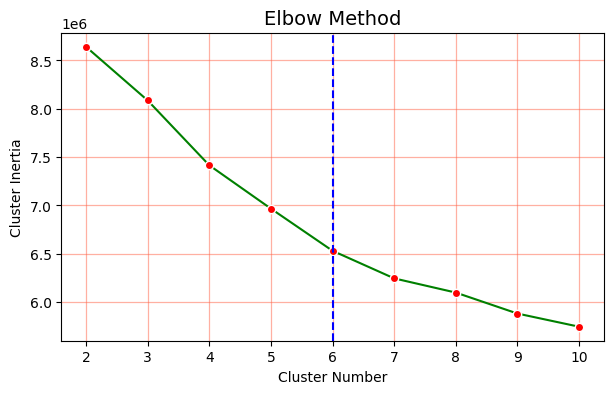

In [30]:
plt.figure(figsize=(7,4))
plt.plot(cluster_num,cluster_inertia,linewidth=1.5,linestyle='-',
         marker='o',markerfacecolor='r',markeredgecolor='w',color='green')
plt.title('Elbow Method',fontsize=14)
plt.xlabel('Cluster Number')
plt.ylabel('Cluster Inertia')
#plt.axvline(4,ls='--',color='blue')
plt.axvline(6,ls='--',color='blue')
plt.grid(color='tomato',linewidth=0.9,alpha=0.5)
plt.show()

In [31]:
kmeans_best=KMeans(n_clusters=6,init='k-means++',n_init='auto',random_state=23).fit(x)
df.loc[:,'Cluster']=kmeans_best.labels_

/opt/conda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



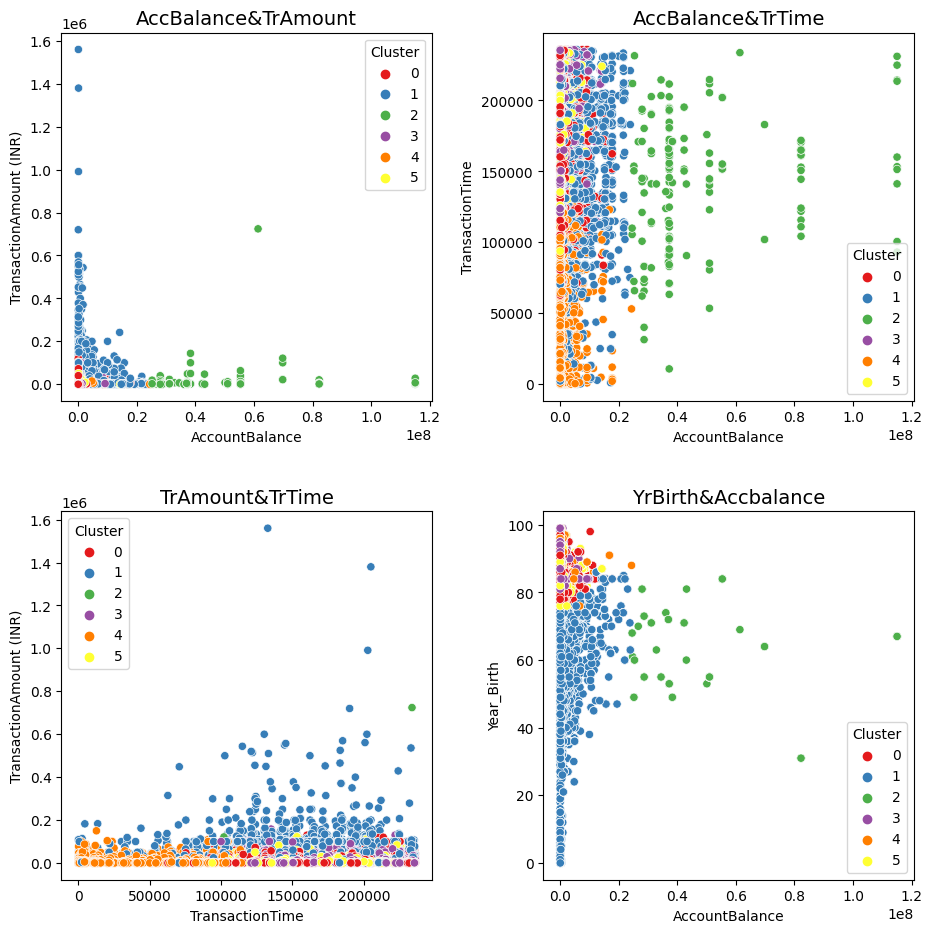

In [32]:
def cluster_data(data=df):
    fig,ax=plt.subplots(2,2,figsize=(11,11))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    sns.scatterplot(ax=ax[0,0],data=data,x='AccountBalance',y='TransactionAmount (INR)',
                    hue='Cluster',palette='Set1')
    sns.scatterplot(ax=ax[0,1],data=data,x='AccountBalance',y='TransactionTime',
                    hue='Cluster',palette='Set1')
    sns.scatterplot(ax=ax[1,0],data=data,x='TransactionTime',y='TransactionAmount (INR)',
                    hue='Cluster',palette='Set1')
    sns.scatterplot(ax=ax[1,1],data=data,x='AccountBalance',y='Year_Birth',
                    hue='Cluster',palette='Set1')
    ax[0,0].set_title('AccBalance&TrAmount',fontsize=14)
    ax[0,1].set_title('AccBalance&TrTime',fontsize=14)
    ax[1,0].set_title('TrAmount&TrTime',fontsize=14)
    ax[1,1].set_title('YrBirth&Accbalance',fontsize=14)
cluster_data(df)

In [33]:
df_dbscan=df.drop('Cluster',axis=1).sample(10000,random_state=23)
X_for_dbscan=full_pipe.fit_transform(df_dbscan)

In [34]:
#bandwidth=estimate_bandwidth(x,quantile=0.1,random_state=23)
#mShift=MeanShift(bandwidth).fit(x)
eps_values=np.arange(1.0,2.6,0.25)
min_samples=np.arange(4,10)
hyper_values=list(product(eps_values,min_samples))
cluster_number=[]
silh_scores=[]
for val in hyper_values:
    dbscan=DBSCAN(eps=val[0],min_samples=val[1]).fit(X_for_dbscan)
    cluster_number.append(len(np.unique(dbscan.labels_)))
    score=silhouette_score(X_for_dbscan,dbscan.labels_)
    silh_scores.append(score)

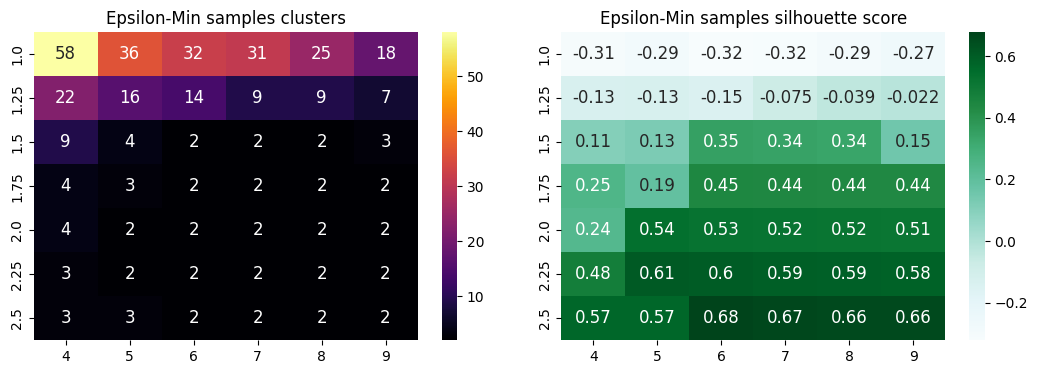

In [35]:
df_cluster=pd.DataFrame(np.array(cluster_number).reshape(7,6),columns=min_samples,index=eps_values)
df_silh_score=pd.DataFrame(np.array(silh_scores).reshape(7,6),columns=min_samples,index=eps_values)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,4))
fig.subplots_adjust(wspace=0.1)
sns.heatmap(ax=ax1,data=df_cluster,cmap='inferno',annot=True,fmt='.2g',annot_kws={'size':12})
sns.heatmap(ax=ax2,data=df_silh_score,cmap='BuGn',annot=True,fmt='.2g',annot_kws={'size':12})
ax1.set_title('Epsilon-Min samples clusters')
ax2.set_title('Epsilon-Min samples silhouette score')
plt.show()

In [44]:
dbscan_result=DBSCAN(eps=2.5,min_samples=5).fit(X_for_dbscan)
df_dbscan.loc[:,'Cluster']=dbscan_result.labels_
df_dbscan['Cluster'].unique()

array([ 0, -1,  1])

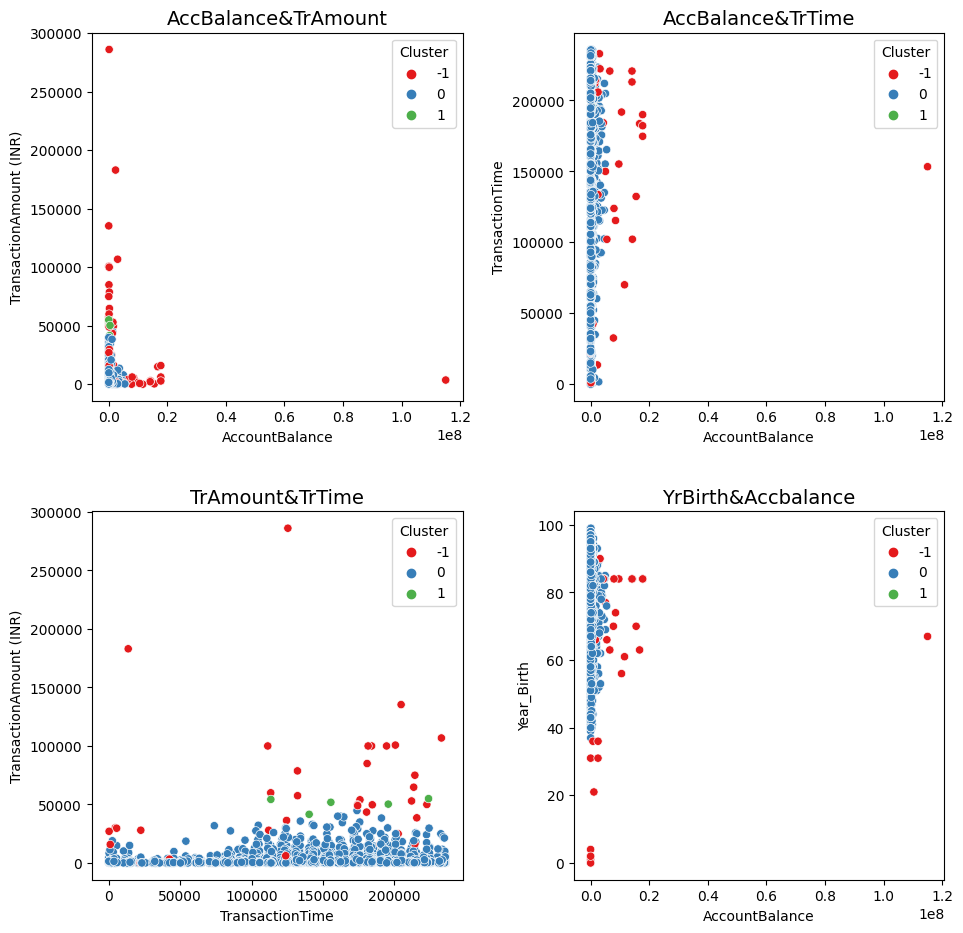

In [45]:
cluster_data(df_dbscan)

In [38]:
bandwidth=estimate_bandwidth(X_for_dbscan,quantile=0.1)
mShift=MeanShift(bandwidth=bandwidth).fit(X_for_dbscan)
np.unique(mShift.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [51]:
df.head()

,Gender,Location,AccountBalance,TransactionTime,TransactionAmount (INR),Day_Birth,Month_Birth,Year_Birth,TransactionDay,TransactionMonth,Age,Cluster
0,M,3523.0,65195.35,134832,4197.0,3.0,1.0,89.0,22,September,27.0,3
1,M,283.0,88.29,31832,70.0,7.0,5.0,88.0,13,August,28.0,4
2,M,3068.0,96774.98,191621,1500.0,15.0,6.0,86.0,13,September,30.0,3
3,M,3068.0,30457.93,215051,1892.0,6.0,11.0,85.0,10,September,31.0,5
4,M,5245.0,108913.62,182819,105.0,31.0,5.0,88.0,2,September,28.0,5


In [53]:
df_3D=df.head(100000)
x,y,z=df_3D['Age'],df_3D['TransactionDay'],df_3D['TransactionTime']
color=df_3D['Cluster']
trace=go.Scatter3d(x=x,y=y,z=z,mode='markers',
                  marker=dict(color=color,size=4,colorscale='Viridis',opacity=0.8))
layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0))
plot=go.Figure(data=[trace],layout=layout)
iplot(plot)

In [ ]:
full_pipe.fit_transform(df)
joblib.dump(full_pipe,'pipeline.jbl')
pipe=joblib.load('pipeline.jbl')
#pipe.transform(df.iloc[[0]])
#kmeans_best.predict(x[[0]])

In [ ]:
file_names_jbl=['KMeans.jbl','DBSCAN.jbl','MeanShift.jbl']
file_names_pkl=['KMeans.pkl','DBSCAN.pkl','MeanShift.pkl']
models=[kmeans_best,dbscan_result,mShift]
for model in models:
    with open(file_names_jbl[models.index(model)],'wb') as file:
        joblib.dump(model,file)
    with open(file_names_pkl[models.index(model)],'wb') as file:
        pickle.dump(model,file)